# 프로젝트: 한국어 데이터로 챗봇 만들기

#### ✔︎ 모듈 불러오기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
## Step 1. 데이터 수집하기

송영숙님이 공개한 챗봇 데이터를 사용할 예정이다.
<br>[데이터 다운로드 링크](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)
<br>
>**Data description** <br>
인공데이터입니다. 일부 이별과 관련된 질문에서 다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 자주 나오는 이야기들을 참고하여 제작하였습니다. 가령 "이별한 지 열흘(또는 100일) 되었어요"라는 질문에 챗봇이 위로한다는 취지로 답변을 작성하였습니다.
<br><br>1. 챗봇 트레이닝용 문답 페어 11,876개
<br>2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [2]:
data_path = os.getenv("HOME") + '/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(data_path)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
print(data.shape)

(11823, 3)


In [4]:
data[data['label'] == 1].head()

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1


In [5]:
data[data['label'] == 2].head()

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2


In [6]:
data.loc[0]

Q            12시 땡!
A        하루가 또 가네요.
label             0
Name: 0, dtype: object

In [7]:
data['Q']

0                         12시 땡!
1                    1지망 학교 떨어졌어
2                   3박4일 놀러가고 싶다
3                3박4일 정도 놀러가고 싶다
4                        PPL 심하네
                  ...           
11818             훔쳐보는 것도 눈치 보임.
11819             훔쳐보는 것도 눈치 보임.
11820                흑기사 해주는 짝남.
11821    힘든 연애 좋은 연애라는게 무슨 차이일까?
11822                 힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [8]:
data['Q'].values

array(['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', ..., '흑기사 해주는 짝남.',
       '힘든 연애 좋은 연애라는게 무슨 차이일까?', '힘들어서 결혼할까봐'], dtype=object)

In [9]:
data['Q'].values[0]

'12시 땡!'

In [10]:
data['A'].values[-1]

'도피성 결혼은 하지 않길 바라요.'

---
## Step 2. 데이터 전처리하기

#### - 전처리 함수
영어와 한국어의 전처리는 많이 다르다.<br>
하나하나 생각해보면서 전처리 해주자.

제거 제외 대상에 한글과 숫자를 추가해준다.

In [11]:
def preprocess_sentence(sentence):

  # 단어와 구두점(punctuation) 사이의 거리를 만들어주기
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (가-힣, a-z, A-Z, 0-9 ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
  sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

#### - 데이터 로드 함수
데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 쌍을 전처리해주는 함수를 만들어준다.

In [12]:
def load_conversations():
    inputs, outputs = [], []
    for i in range(len(data)):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용
        inputs.append(preprocess_sentence(data['Q'].values[i]))
        outputs.append(preprocess_sentence(data['A'].values[i]))
    return inputs, outputs

데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장해준다.

In [13]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야 한다.

In [14]:
for i in range(5):
    print('전처리 후의 {}번째 질문 샘플: {}'.format(i+1, questions[i]))
    print('전처리 후의 {}번째 답변 샘플: {}'.format(i+1, answers[i]))

전처리 후의 1번째 질문 샘플: 12시 땡 !
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 .
전처리 후의 2번째 질문 샘플: 1지망 학교 떨어졌어
전처리 후의 2번째 답변 샘플: 위로해 드립니다 .
전처리 후의 3번째 질문 샘플: 3박4일 놀러가고 싶다
전처리 후의 3번째 답변 샘플: 여행은 언제나 좋죠 .
전처리 후의 4번째 질문 샘플: 3박4일 정도 놀러가고 싶다
전처리 후의 4번째 답변 샘플: 여행은 언제나 좋죠 .
전처리 후의 5번째 질문 샘플: PPL 심하네
전처리 후의 5번째 답변 샘플: 눈살이 찌푸려지죠 .


---
## Step 3. SubwordTextEncoder 사용하기

텐서플로의 내부 토크나이저인 SubwordTextEncoder를 사용해서 토크나이징을 해준다.
<br> 시간이 된다면 지난번에 썼던 형태소 분석기도 사용해보자.

#### - 단어장(Vocabulary) 만들기
각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어준다.
<br> 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만든다.

In [15]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8162]
END_TOKEN의 번호 : [8163]


In [16]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8164


#### - 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

tokenizer를 정의하고 Vocabulary를 만들었다면
- tokenizer.encode()로 각 단어를 정수로 변환할 수 있고
- tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

In [17]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환

print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('디코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.decode(tokenizer.encode(questions[21]))))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))
print('디코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.decode(tokenizer.encode(answers[21]))))

정수 인코딩 후의 21번째 질문 샘플: [5757, 610, 2486, 4158]
디코딩 후의 21번째 질문 샘플: 가스비 장난 아님
정수 인코딩 후의 21번째 답변 샘플: [2355, 7502, 7, 6266, 97, 1]
디코딩 후의 21번째 답변 샘플: 다음 달에는 더 절약해봐요 .


문장의 최대 길이를 정하기 위해 문장 길이들을 살펴볼 필요가 있다.

In [18]:
question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(question_len)))
print('질문의 최대 길이 : {}'.format(np.max(question_len)))
print('질문의 평균 길이 : {}'.format(np.mean(question_len)))
print('답변의 최소 길이 : {}'.format(np.min(answer_len)))
print('답변의 최대 길이 : {}'.format(np.max(answer_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answer_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.9378330373001775
답변의 최소 길이 : 1
답변의 최대 길이 : 24
답변의 평균 길이 : 4.716146494121627


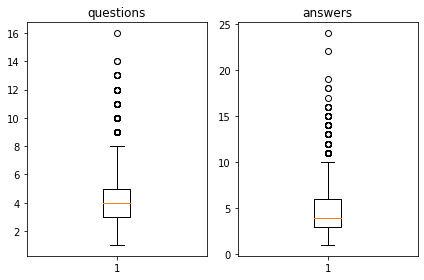

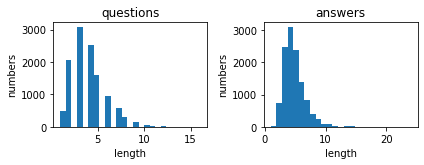

In [19]:
# 길이 분포 확인
plt.subplot(1,2,1)
plt.boxplot(question_len)
plt.title('questions')
plt.subplot(1,2,2)
plt.boxplot(answer_len)
plt.title('answers')
plt.tight_layout()
plt.show()

plt.subplot(2,2,1)
plt.title('questions')
plt.hist(question_len, bins = 25)
plt.xlabel('length')
plt.ylabel('numbers')
plt.subplot(2,2,2)
plt.title('answers')
plt.hist(answer_len, bins = 25)
plt.xlabel('length')
plt.ylabel('numbers')
plt.tight_layout()
plt.show()

In [20]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 30


In [21]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩해주는 함수
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 30 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 30로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 11822
필터링 후의 답변 샘플 개수: 11822


#### - Teacher Forcing 사용하기

In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

---
## Step 4. 모델 구성하기

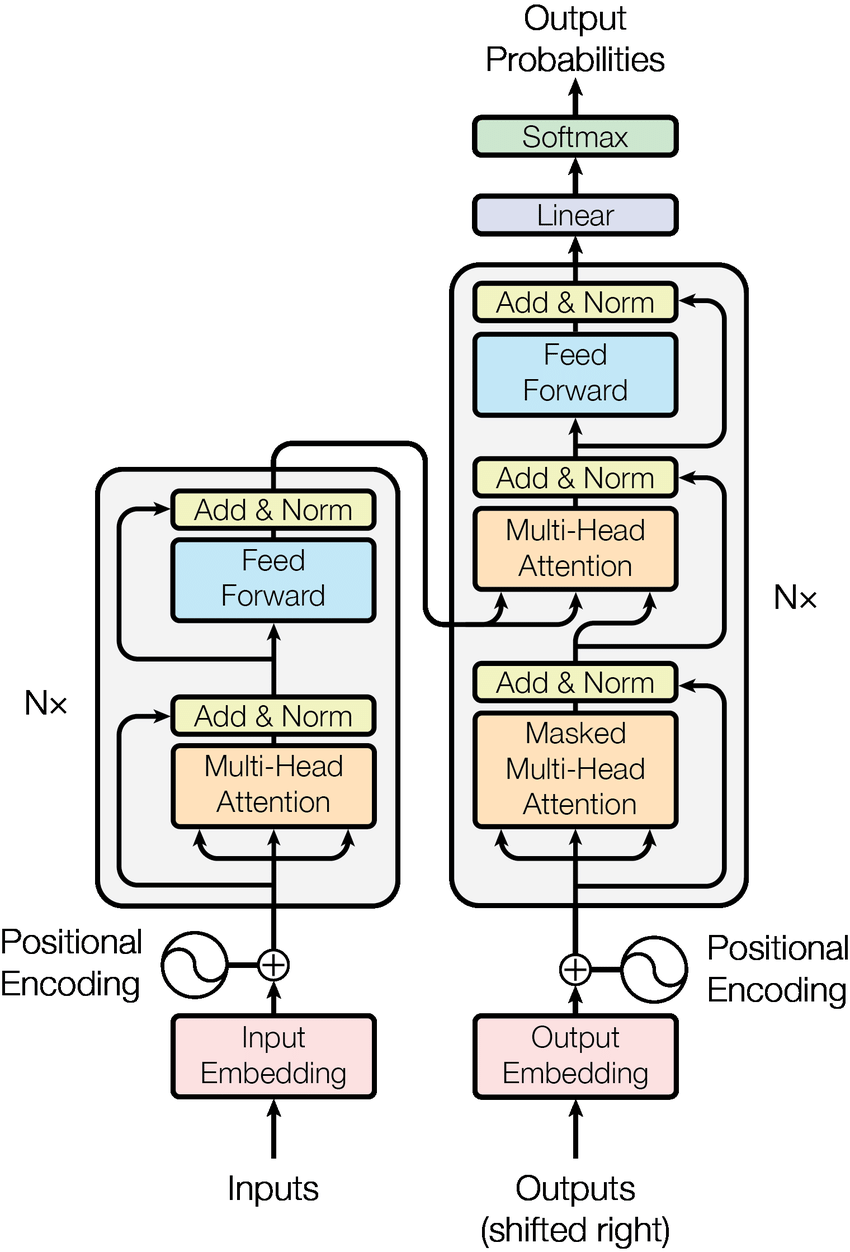

### 1) 기본 메커니즘 함수 & 클래스

#### - Scaled dot product attention

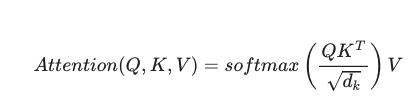

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구해준다(벡터의 내적, 스케일링, 소프트맥스 함수 이용). 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해 준다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 최종 결과인 어텐션 값(Attention Value)이 계산된다.

In [24]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

#### - padding mask

In [25]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

이 함수에 정수 시퀀스를 입력으로 하면, 숫자가 0인 부분을 체크한 벡터를 리턴한다.
<br> 즉, 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력한다.
<br> 어텐션 연산 시에 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있다.

In [26]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


#### - Look-ahead masking (다음 단어 가리기)

In [27]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)  # 패딩마스크 함수도 끼워넣기
  return tf.maximum(look_ahead_mask, padding_mask)

트랜스포머의 경우 전체 문장이 문장 행렬로 들어가므로 위치와 상관없이 모든 단어를 참고 해서 다음 단어를 예측할 수 있다. 하지만 우리는 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 해야하기 때문에, 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법을 써야 한다.
<br> Look-ahead masking 기법은 Query 단어 뒤에 나오는 Key 단어들에 대해서 마스킹해준다.

In [28]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [29]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


#### - Positional Encoding 레이어

트랜스포머는 문장에 있는 모든 단어를 한꺼번에 입력으로 받으므로 어순 정보를 추가로 알려줄 필요가 있다. 따라서 단어의 임베딩 벡터에 위치정보를 가진 벡터값을 더해서 모델의 입력으로 삼기 위해 포지셔닝 인코딩 레이어를 사용한다.

In [30]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


#### - Multi-head attention

어텐션을 병렬로 수행하여 놓칠만한 정보를 더 꼼꼼히 보게끔 한다.

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만들기
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용
    outputs = self.dense(concat_attention)

    return outputs

### 2) 모델 쌓기

#### - 인코더

하나의 인코더 층은 크게 Self-Attention, Feed forward Neural Network의 총 2개의 서브 층(sublayer)으로 나누어진다.<br>
Self-Attention은 Multi-head Attention으로 병렬적으로 이루어진다.

In [32]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

이렇게 인코더 층을 구현한 후 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용된다.


In [33]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### - 디코더

디코더는 세 개의 서브 층으로 구성된다. 
<br>첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망이다. 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다.

인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행한다.

In [34]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

이렇게 디코더의 층을 구현한 후, 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, num_layers 개수의 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

In [35]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#### - Transformer 모델 함수 구현하기

In [36]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용
  # 내부적으로 패딩 마스크도 포함되어져 있음
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 3) 모델 학습하기

#### - 모델 생성

In [37]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3144192     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### - 손실함수

In [38]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)  # 패딩 마스크 적용

  return tf.reduce_mean(loss)

#### - Learning rate

Custom Learning rate Scheduling :
    <br>모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법

In [39]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

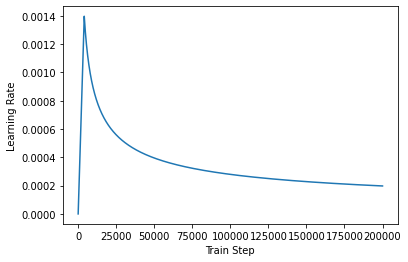

In [40]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### - 모델 컴파일
손실함수와 커스텀 된 learning rate를 사용하여 모델을 컴파일 해준다.
<br> 최적화 기법은 Adam을 사용한다.

In [41]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### - 모델 훈련하기

In [42]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 14s 46ms/step - loss: 1.9419 - accuracy: 0.0429
Epoch 2/50
185/185 [==============================] - 8s 46ms/step - loss: 1.5783 - accuracy: 0.0666
Epoch 3/50
185/185 [==============================] - 8s 46ms/step - loss: 1.3478 - accuracy: 0.0681
Epoch 4/50
185/185 [==============================] - 8s 45ms/step - loss: 1.2476 - accuracy: 0.0729
Epoch 5/50
185/185 [==============================] - 8s 45ms/step - loss: 1.1693 - accuracy: 0.0773
Epoch 6/50
185/185 [==============================] - 8s 45ms/step - loss: 1.0899 - accuracy: 0.0829
Epoch 7/50
185/185 [==============================] - 8s 45ms/step - loss: 1.0019 - accuracy: 0.0908
Epoch 8/50
185/185 [==============================] - 8s 45ms/step - loss: 0.9049 - accuracy: 0.1016
Epoch 9/50
185/185 [==============================] - 8s 45ms/step - loss: 0.7984 - accuracy: 0.1129
Epoch 10/50
185/185 [==============================] - 8s 46ms/step - loss: 0.6881 - accur

---

## Step 5. 모델 평가하기

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 decoder_inference() 함수를 만들어준다.

In [43]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됨
    # 이 output_sequence는 다시 디코더의 입력이 된다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만들어준다.

In [44]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

In [45]:
sentence_generation('힘들다')

입력 : 힘들다
출력 : 휴가가 간절하겠네요 .


In [46]:
sentence_generation('체력이 떨어졌어')

입력 : 체력이 떨어졌어
출력 : 사람들이 중간을 몰라요 .


In [47]:
sentence_generation('여행을 어디로 가면 좋을까?')

입력 : 여행을 어디로 가면 좋을까?
출력 : 혼자 힘들어하지 마세요 .


In [48]:
sentence_generation('술마시고 싶다')

입력 : 술마시고 싶다
출력 : 한 잔하기 좋은 날이네요 .


In [49]:
sentence_generation('잘하고 있는거겠지?')

입력 : 잘하고 있는거겠지?
출력 : 있을 거예요 .


In [50]:
sentence_generation('좋은 얘기 해줘서 고마워')

입력 : 좋은 얘기 해줘서 고마워
출력 : 뭐라도 얘기를 하면 좀 나아질 거예요 .


In [51]:
sentence_generation('sns의 폐해는?')

입력 : sns의 폐해는?
출력 : SNS 보지 마세요 .


---
# 회고

- 처음에 데이터 전처리 함수를 만들 때 이번엔 영어가 아닌 한글로 진행되니깐<br>
`sentence = sentence.lower().strip()` 이 코드를 빼주어야한다고 생각했다.<br> 근데 진행하다가 중간중간에 'PPL'이나 'SNS'와 같은 영어도 들어간다는 것을 보고 괜히 빼주는 것인가? 하고 끝까지 진행한 뒤에 결과를 비교해볼까 했는데, 저 코드를 빼주어도 답변 결과물들은 괜찮게 나오는 것 같다. 심지어 마지막 문장에서 sns를 소문자로 입력했는데 대문자로 답변이 돌아온 것을 보면 어느 정도 같은 단어로 인식하고 있음을 알 수 있다. 데이터 양도 적고 그래서 딱히 중요한 부분은 아닌 것 같다.
<br><br>
- accuracy값이 낮게 나와서 모델 학습 후에 걱정을 했는데 결과물이 괜찮게 잘 나오는 것을 보니 accuracy는 딱히 중요한 metrics는 아닌 듯 하다. 그렇다면 직접 입력해서 출력을 확인해보는 것 말고 모델 평가 기준을 무엇으로 정해놓고 판단해야하는지 궁금하다.
<br><br>
- 데이터 전처리 과정에 많은 공을 들이지도 않았고, 모델 학습 시간도 그렇게 오래 걸리지 않았는데 결과물이 좋은 것에 약간 놀랐다. 이렇게 될 수 있는 이유에 대해서 생각해봤는데,
<br> 1) 첫번째로 기본 데이터셋의 질이 좋아서 그런 것 같았다. 가져온 챗봇 데이터를 살펴보면 모델을 훈련시켰을 때 학습이 잘 되게끔 정제된 문장들을 많이 사용한 듯 싶다.
<br> 2) 두번째로 텐서플로의 내장 토크나이저인 SubwordTextEncoder가 꽤 좋은 것 같다. 많은 작업들을 해주지 않아도 형태소 분석을 수월하게 해서 좋은 토크나이징이 나온 것 같다.
<br> 3) 세번째로는 Teacher Forcing이 학습에 엄청 도움이 된 것 같다. 바로 직전의 예측값을 넣지 않고 정답을 넣어서 훈련시킴으로써 잘못된 예측을 방지하고 이것이 학습의 속도와 정확도에 크게 기여한 듯 싶다.
<br> 4) 네번째로는 트랜스포머의 모델 구성 덕분인 것 같다. 기존 RNN 모델보다 훨씬 더 복잡하고 업그레이드 된 레이어들이 쓰이고 그것을 쌓는 구성도 훨씬 복잡하다. 덕분에 이해하는 게 너무 어렵고 그냥 갖다쓴 모양새가 되었지만, 이렇게 고급으로 만들어진 모델을 사용함으로써 모델 선택의 중요성을 알게되었다. 쓰인 코드들은 더 공부해야겠지만, 앞으로 더 고도화된 모델들을 보는 것이 기대가 된다.
<br><br>
- NLP는 어렵지만, 이렇게 결과물들이 나오는 것을 보면 항상 재미있긴 하다. 또 RNN 모델들이 생성모델들과 구조가 비슷하고, 연속된 데이터들을 다루니깐 언제까지나 무시하고 갈 수는 없는 것 같다. 앞으로 좀더 계속 공부를 열심히 해봐야겠다.